# Experiment Templates Demo

This notebook demonstrates the experiment framework for dolphin acoustic analysis.

## What You'll Learn

1. Using pre-built experiment pipelines
2. Running batch experiments
3. Comparing different methods
4. Creating custom pipelines
5. Analyzing and visualizing results

## Prerequisites

Make sure dolphain is installed:
```bash
pip install -e .
```

In [1]:
# Import libraries
import sys
import importlib

# Force reload of dolphain modules by removing from cache
modules_to_reload = [k for k in sys.modules.keys() if k.startswith('dolphain')]
for mod in modules_to_reload:
    del sys.modules[mod]

# Now import fresh
import dolphain
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

%matplotlib inline

print("✓ Modules reloaded successfully")

✓ Modules reloaded successfully


## Part 1: Basic Metrics Pipeline

The simplest pipeline - extract fundamental acoustic properties.

In [2]:
# Create pipeline
pipeline = dolphain.BasicMetricsPipeline()

# Test on one file first
test_files = dolphain.find_data_files('../data', '**/*.210')
result = pipeline(test_files[0])

print("Basic metrics for one file:")
for key, value in result.items():
    print(f"  {key}: {value:.4f}")

Basic metrics for one file:
  duration: 21.3333
  n_samples: 4096000.0000
  rms: 126.5189
  peak: 193.0000
  dynamic_range: 11.5597
  zero_crossing_rate: 0.0000


In [3]:
# Run on multiple files
results = dolphain.run_experiment(
    name="Basic Metrics Analysis",
    pipeline=pipeline,
    data_dir="../data",
    n_files=20,
    seed=42,
    verbose=False
)


EXPERIMENT: Basic Metrics Analysis

Found 100 files
Selected 20 files (seed=42)

Processing 20 files...
----------------------------------------------------------------------
----------------------------------------------------------------------
Completed in 3.73s


BATCH PROCESSING SUMMARY
Total files processed: 20
Successful: 20
Failed: 0
Success rate: 100.0%

----------------------------------------------------------------------
TIMING STATISTICS
----------------------------------------------------------------------

per_file:
  Total: 3.73s
  Mean:  0.187s ± 0.002s
  Range: [0.184s, 0.191s]

total_batch:
  Total: 3.73s
  Mean:  3.733s ± 0.000s
  Range: [3.733s, 3.733s]

----------------------------------------------------------------------
METRIC STATISTICS
----------------------------------------------------------------------

duration:
  Mean:   21.333 ± 0.000
  Median: 21.333
  Range:  [21.333, 21.333]

n_samples:
  Mean:   4096000.000 ± 0.000
  Median: 4096000.000
  Range:  [4

In [4]:
# Convert to DataFrame for analysis
df_basic = pd.DataFrame(results.results)
df_basic['filename'] = df_basic['file'].apply(lambda x: Path(x).name)
df_basic.head()

,file,duration,n_samples,rms,peak,dynamic_range,zero_crossing_rate,filename
0,../data/Buoy210_100300_100399/718586EF.210,21.333333,4096000,126.518921,193.0,11.559743,0.000000,718586EF.210
1,../data/Buoy210_100300_100399/71858737.210,21.333333,4096000,125.994901,175.0,7.244489,0.000000,71858737.210
2,../data/Buoy210_100300_100399/718587A3.210,21.333333,4096000,125.811933,438.0,252.829482,0.000243,718587A3.210
3,../data/Buoy210_100300_100399/718587C7.210,21.333333,4096000,125.759517,384.0,45.666025,0.000007,718587C7.210
4,../data/Buoy210_100300_100399/718587E0.210,21.333333,4096000,126.195838,192.0,11.018149,0.000000,718587E0.210


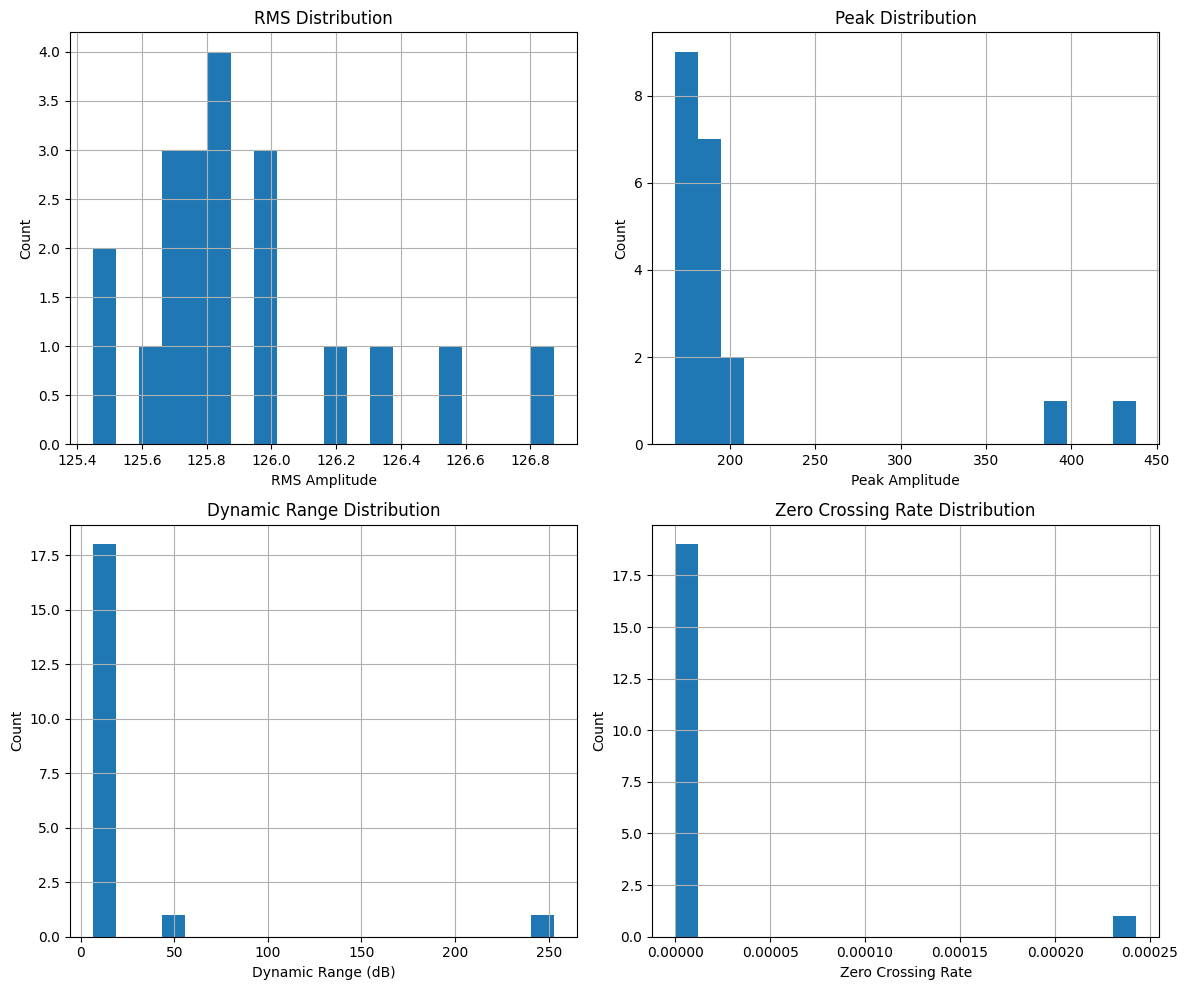

In [5]:
# Visualize distributions
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

df_basic['rms'].hist(bins=20, ax=axes[0, 0])
axes[0, 0].set_xlabel('RMS Amplitude')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('RMS Distribution')

df_basic['peak'].hist(bins=20, ax=axes[0, 1])
axes[0, 1].set_xlabel('Peak Amplitude')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Peak Distribution')

df_basic['dynamic_range'].hist(bins=20, ax=axes[1, 0])
axes[1, 0].set_xlabel('Dynamic Range (dB)')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Dynamic Range Distribution')

df_basic['zero_crossing_rate'].hist(bins=20, ax=axes[1, 1])
axes[1, 1].set_xlabel('Zero Crossing Rate')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Zero Crossing Rate Distribution')

plt.tight_layout()
plt.show()

## Part 2: Whistle Detection Pipeline

Detect and characterize dolphin whistles.

In [6]:
# Create pipeline with denoising
pipeline_whistle = dolphain.WhistleDetectionPipeline(
    denoise=True,
    power_threshold_percentile=85.0,
    min_duration=0.1
)

# Run experiment
results_whistle = dolphain.run_experiment(
    name="Whistle Detection",
    pipeline=pipeline_whistle,
    data_dir="../data",
    n_files=20,
    seed=42,
    verbose=False
)


EXPERIMENT: Whistle Detection

Found 100 files
Selected 20 files (seed=42)

Processing 20 files...
----------------------------------------------------------------------
----------------------------------------------------------------------
Completed in 18.63s


BATCH PROCESSING SUMMARY
Total files processed: 20
Successful: 20
Failed: 0
Success rate: 100.0%

----------------------------------------------------------------------
TIMING STATISTICS
----------------------------------------------------------------------

per_file:
  Total: 18.63s
  Mean:  0.932s ± 0.222s
  Range: [0.717s, 1.749s]

total_batch:
  Total: 18.63s
  Mean:  18.631s ± 0.000s
  Range: [18.631s, 18.631s]

----------------------------------------------------------------------
METRIC STATISTICS
----------------------------------------------------------------------

n_whistles:
  Mean:   62.300 ± 19.789
  Median: 69.500
  Range:  [1.000, 85.000]

mean_whistle_duration:
  Mean:   0.202 ± 0.065
  Median: 0.180
  Range: 

In [7]:
# Analyze whistle detection results
if len(results_whistle.results) > 0:
    df_whistle = pd.DataFrame(results_whistle.results)
    df_whistle['filename'] = df_whistle['file'].apply(lambda x: Path(x).name)

    print(f"Total files analyzed: {len(df_whistle)}")
    print(f"Files with whistles: {(df_whistle['n_whistles'] > 0).sum()}")
    print(f"Mean whistles per file: {df_whistle['n_whistles'].mean():.2f}")
    print(f"Max whistles in a file: {df_whistle['n_whistles'].max()}")
else:
    print("⚠️  No successful results. All files failed during processing.")
    print(f"Total errors: {len(results_whistle.errors)}")
    if results_whistle.errors:
        print("\nFirst few errors:")
        for error in results_whistle.errors[:3]:
            print(f"  {Path(error['file']).name}: {error['error_type']} - {error['error']}")
    # Create empty DataFrame for compatibility with later cells
    df_whistle = pd.DataFrame()

Total files analyzed: 20
Files with whistles: 20
Mean whistles per file: 62.30
Max whistles in a file: 85


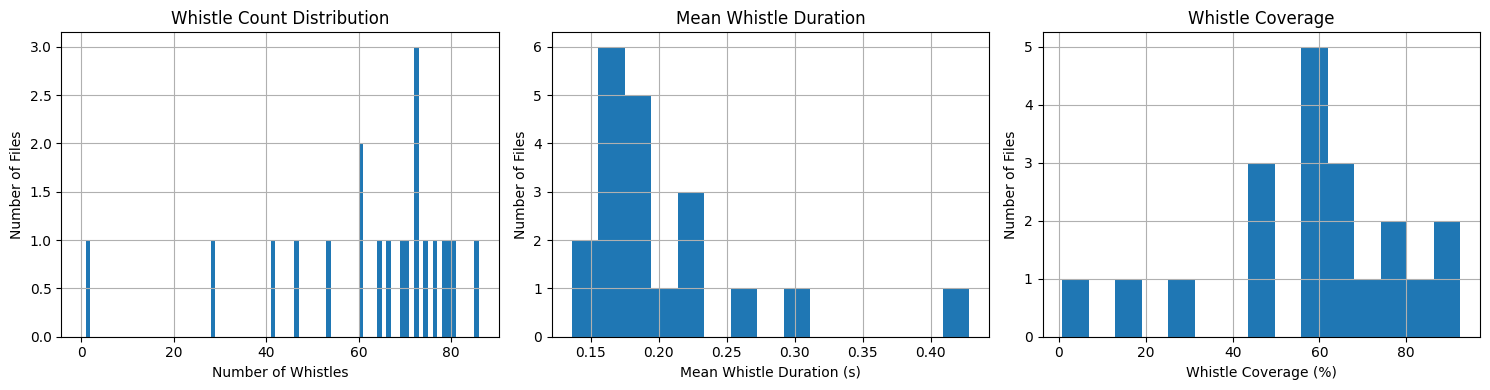

In [8]:
# Visualize whistle statistics
if len(df_whistle) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Whistle counts
    df_whistle['n_whistles'].hist(bins=range(0, int(df_whistle['n_whistles'].max()) + 2), ax=axes[0])
    axes[0].set_xlabel('Number of Whistles')
    axes[0].set_ylabel('Number of Files')
    axes[0].set_title('Whistle Count Distribution')

    # Mean duration (for files with whistles)
    df_with_whistles = df_whistle[df_whistle['n_whistles'] > 0]
    if len(df_with_whistles) > 0:
        df_with_whistles['mean_whistle_duration'].hist(bins=15, ax=axes[1])
        axes[1].set_xlabel('Mean Whistle Duration (s)')
        axes[1].set_ylabel('Number of Files')
        axes[1].set_title('Mean Whistle Duration')
    else:
        axes[1].text(0.5, 0.5, 'No whistles detected', ha='center', va='center', transform=axes[1].transAxes)
        axes[1].set_title('Mean Whistle Duration')

    # Coverage
    df_whistle['whistle_coverage_percent'].hist(bins=15, ax=axes[2])
    axes[2].set_xlabel('Whistle Coverage (%)')
    axes[2].set_ylabel('Number of Files')
    axes[2].set_title('Whistle Coverage')

    plt.tight_layout()
    plt.show()
else:
    print("⚠️  No results to visualize. Please check the errors in the previous cell.")

## Part 3: Method Comparison

Compare different whistle detection approaches.

In [9]:
# Define methods to compare
methods = {
    'No Denoising': dolphain.WhistleDetectionPipeline(
        denoise=False,
        power_threshold_percentile=85.0
    ),
    'With Denoising': dolphain.WhistleDetectionPipeline(
        denoise=True,
        power_threshold_percentile=85.0
    ),
    'Conservative': dolphain.WhistleDetectionPipeline(
        denoise=True,
        power_threshold_percentile=90.0  # Higher = more conservative
    ),
}

# Run comparison (uses same files for all methods)
comparison_results = dolphain.compare_methods(
    method_name="Denoising Effect on Detection",
    pipelines=methods,
    data_dir="../data",
    n_files=15,
    seed=42
)


METHOD COMPARISON: Denoising Effect on Detection

Using 15 files for comparison


----------------------------------------------------------------------
Method: No Denoising
----------------------------------------------------------------------

Processing 15 files...
----------------------------------------------------------------------
----------------------------------------------------------------------
Completed in 29.63s

✓ Processed 15/15 files

----------------------------------------------------------------------
Method: With Denoising
----------------------------------------------------------------------

Processing 15 files...
----------------------------------------------------------------------
----------------------------------------------------------------------
Completed in 29.63s

✓ Processed 15/15 files

----------------------------------------------------------------------
Method: With Denoising
----------------------------------------------------------------------


In [10]:
# Compare results
comparison_data = []
for method_name, collector in comparison_results.items():
    df_method = pd.DataFrame(collector.results)
    comparison_data.append({
        'Method': method_name,
        'Mean Whistles': df_method['n_whistles'].mean(),
        'Std Whistles': df_method['n_whistles'].std(),
        'Mean Coverage %': df_method['whistle_coverage_percent'].mean(),
        'Files with Whistles': (df_method['n_whistles'] > 0).sum(),
    })

df_comparison = pd.DataFrame(comparison_data)
print(df_comparison.to_string(index=False))

        Method  Mean Whistles  Std Whistles  Mean Coverage %  Files with Whistles
  No Denoising       0.266667      0.457738         0.156667                    4
With Denoising      61.866667     20.528262        61.536667                   15
  Conservative      56.066667     20.592879        51.321667                   14


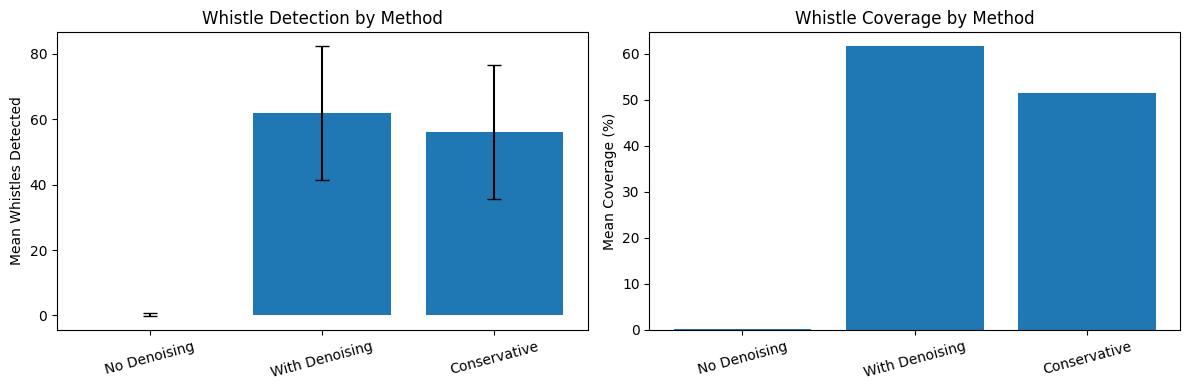

In [11]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar plot of mean whistles detected
axes[0].bar(df_comparison['Method'], df_comparison['Mean Whistles'], 
            yerr=df_comparison['Std Whistles'], capsize=5)
axes[0].set_ylabel('Mean Whistles Detected')
axes[0].set_title('Whistle Detection by Method')
axes[0].tick_params(axis='x', rotation=15)

# Bar plot of coverage
axes[1].bar(df_comparison['Method'], df_comparison['Mean Coverage %'])
axes[1].set_ylabel('Mean Coverage (%)')
axes[1].set_title('Whistle Coverage by Method')
axes[1].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

## Part 4: Spectral Analysis Pipeline

Analyze frequency content across different bands.

In [12]:
# Create spectral analysis pipeline with custom bands
bands = {
    'low': (0, 5000),
    'whistle_low': (5000, 15000),
    'whistle_high': (15000, 25000),
    'ultrasonic': (25000, 100000),
}

pipeline_spectral = dolphain.SpectralAnalysisPipeline(freq_bands=bands)

# Run experiment
results_spectral = dolphain.run_experiment(
    name="Spectral Analysis",
    pipeline=pipeline_spectral,
    data_dir="../data",
    n_files=15,
    seed=42,
    verbose=False
)


EXPERIMENT: Spectral Analysis

Found 100 files
Selected 15 files (seed=42)

Processing 15 files...
----------------------------------------------------------------------
----------------------------------------------------------------------
Completed in 4.65s


BATCH PROCESSING SUMMARY
Total files processed: 15
Successful: 15
Failed: 0
Success rate: 100.0%

----------------------------------------------------------------------
TIMING STATISTICS
----------------------------------------------------------------------

per_file:
  Total: 4.65s
  Mean:  0.310s ± 0.041s
  Range: [0.256s, 0.407s]

total_batch:
  Total: 4.65s
  Mean:  4.651s ± 0.000s
  Range: [4.651s, 4.651s]

----------------------------------------------------------------------
METRIC STATISTICS
----------------------------------------------------------------------

low_total_power:
  Mean:   6.804 ± 2.900
  Median: 4.887
  Range:  [4.203, 12.212]

low_mean_power:
  Mean:   0.032 ± 0.014
  Median: 0.023
  Range:  [0.020, 0.

In [13]:
# Analyze spectral results
df_spectral = pd.DataFrame(results_spectral.results)
df_spectral['filename'] = df_spectral['file'].apply(lambda x: Path(x).name)

# Calculate relative power in each band
total_power = (df_spectral['low_total_power'] + 
               df_spectral['whistle_low_total_power'] + 
               df_spectral['whistle_high_total_power'] + 
               df_spectral['ultrasonic_total_power'])

df_spectral['low_rel'] = df_spectral['low_total_power'] / total_power * 100
df_spectral['whistle_low_rel'] = df_spectral['whistle_low_total_power'] / total_power * 100
df_spectral['whistle_high_rel'] = df_spectral['whistle_high_total_power'] / total_power * 100
df_spectral['ultrasonic_rel'] = df_spectral['ultrasonic_total_power'] / total_power * 100

print("Mean relative power by frequency band:")
print(f"  Low (0-5 kHz): {df_spectral['low_rel'].mean():.1f}%")
print(f"  Whistle Low (5-15 kHz): {df_spectral['whistle_low_rel'].mean():.1f}%")
print(f"  Whistle High (15-25 kHz): {df_spectral['whistle_high_rel'].mean():.1f}%")
print(f"  Ultrasonic (25-100 kHz): {df_spectral['ultrasonic_rel'].mean():.1f}%")

Mean relative power by frequency band:
  Low (0-5 kHz): 93.8%
  Whistle Low (5-15 kHz): 0.9%
  Whistle High (15-25 kHz): 0.7%
  Ultrasonic (25-100 kHz): 4.6%


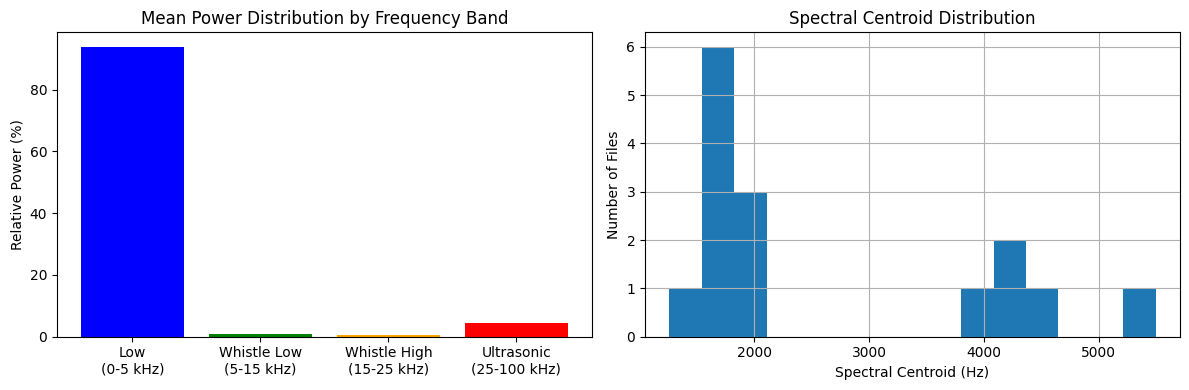

In [14]:
# Visualize spectral distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Stacked bar chart of relative power
bands_rel = ['low_rel', 'whistle_low_rel', 'whistle_high_rel', 'ultrasonic_rel']
band_labels = ['Low\n(0-5 kHz)', 'Whistle Low\n(5-15 kHz)', 
               'Whistle High\n(15-25 kHz)', 'Ultrasonic\n(25-100 kHz)']

mean_powers = [df_spectral[band].mean() for band in bands_rel]
axes[0].bar(band_labels, mean_powers, color=['blue', 'green', 'orange', 'red'])
axes[0].set_ylabel('Relative Power (%)')
axes[0].set_title('Mean Power Distribution by Frequency Band')
axes[0].tick_params(axis='x', rotation=0)

# Spectral centroid distribution
df_spectral['spectral_centroid'].hist(bins=15, ax=axes[1])
axes[1].set_xlabel('Spectral Centroid (Hz)')
axes[1].set_ylabel('Number of Files')
axes[1].set_title('Spectral Centroid Distribution')

plt.tight_layout()
plt.show()

## Part 5: Custom Pipeline

Create your own custom analysis pipeline.

In [15]:
from pathlib import Path
from typing import Dict, Any

class CustomAnalysisPipeline:
    """
    Custom pipeline that combines multiple analyses.
    """
    
    def __init__(self, apply_denoise: bool = True):
        self.apply_denoise = apply_denoise
    
    def __call__(self, filepath: Path) -> Dict[str, Any]:
        """Process a file."""
        # Read data
        data = dolphain.read_ears_file(filepath)
        signal = data["data"]
        
        # Optionally denoise
        if self.apply_denoise:
            signal_clean = dolphain.wavelet_denoise(signal, wavelet='db8')
        else:
            signal_clean = signal
        
        # Calculate custom metrics
        # 1. Signal-to-noise ratio (if denoised)
        if self.apply_denoise:
            noise = signal - signal_clean
            snr = 10 * np.log10(
                np.mean(signal_clean ** 2) / (np.mean(noise ** 2) + 1e-10)
            )
        else:
            snr = 0.0
        
        # 2. Energy in different time segments
        n_segments = 4
        segment_length = len(signal_clean) // n_segments
        segment_energies = []
        for i in range(n_segments):
            start = i * segment_length
            end = start + segment_length
            segment = signal_clean[start:end]
            energy = np.sum(segment ** 2)
            segment_energies.append(float(energy))
        
        # 3. Peak-to-average ratio
        peak_to_avg = float(np.max(np.abs(signal_clean)) / (np.mean(np.abs(signal_clean)) + 1e-10))
        
        return {
            "duration": data["duration"],
            "snr_db": float(snr),
            "segment1_energy": segment_energies[0],
            "segment2_energy": segment_energies[1],
            "segment3_energy": segment_energies[2],
            "segment4_energy": segment_energies[3],
            "peak_to_avg_ratio": peak_to_avg,
        }

# Test custom pipeline
custom_pipeline = CustomAnalysisPipeline(apply_denoise=True)
result = custom_pipeline(test_files[0])

print("Custom pipeline result:")
for key, value in result.items():
    print(f"  {key}: {value:.4f}")

Custom pipeline result:
  duration: 21.3333
  snr_db: -18.6657
  segment1_energy: 88681543.5399
  segment2_energy: 264405653.0636
  segment3_energy: 267947469.5364
  segment4_energy: 256747949.8386
  peak_to_avg_ratio: 4.2864


In [16]:
# Run custom pipeline experiment
results_custom = dolphain.run_experiment(
    name="Custom Analysis",
    pipeline=custom_pipeline,
    data_dir="../data",
    n_files=15,
    seed=42,
    verbose=False
)


EXPERIMENT: Custom Analysis

Found 100 files
Selected 15 files (seed=42)

Processing 15 files...
----------------------------------------------------------------------
----------------------------------------------------------------------
Completed in 4.91s


BATCH PROCESSING SUMMARY
Total files processed: 15
Successful: 15
Failed: 0
Success rate: 100.0%

----------------------------------------------------------------------
TIMING STATISTICS
----------------------------------------------------------------------

per_file:
  Total: 4.91s
  Mean:  0.327s ± 0.012s
  Range: [0.318s, 0.368s]

total_batch:
  Total: 4.91s
  Mean:  4.908s ± 0.000s
  Range: [4.908s, 4.908s]

----------------------------------------------------------------------
METRIC STATISTICS
----------------------------------------------------------------------

duration:
  Mean:   21.333 ± 0.000
  Median: 21.333
  Range:  [21.333, 21.333]

snr_db:
  Mean:   -20.929 ± 1.629
  Median: -22.036
  Range:  [-22.710, -18.200]



Energy distribution across time segments:
max_segment
1    3
2    6
3    5
4    1
Name: count, dtype: int64


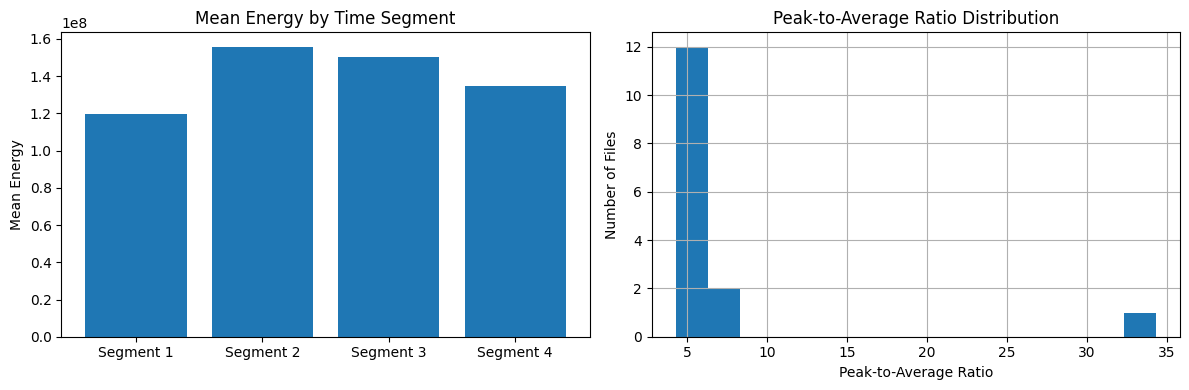

In [17]:
# Analyze temporal energy distribution
df_custom = pd.DataFrame(results_custom.results)

# Calculate which segment has most energy
segment_cols = ['segment1_energy', 'segment2_energy', 'segment3_energy', 'segment4_energy']
df_custom['max_segment'] = df_custom[segment_cols].idxmax(axis=1)
df_custom['max_segment'] = df_custom['max_segment'].str.replace('segment', '').str.replace('_energy', '')

print("Energy distribution across time segments:")
print(df_custom['max_segment'].value_counts().sort_index())

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar plot of mean energy per segment
mean_energies = [df_custom[col].mean() for col in segment_cols]
axes[0].bar(['Segment 1', 'Segment 2', 'Segment 3', 'Segment 4'], mean_energies)
axes[0].set_ylabel('Mean Energy')
axes[0].set_title('Mean Energy by Time Segment')

# Peak-to-average ratio distribution
df_custom['peak_to_avg_ratio'].hist(bins=15, ax=axes[1])
axes[1].set_xlabel('Peak-to-Average Ratio')
axes[1].set_ylabel('Number of Files')
axes[1].set_title('Peak-to-Average Ratio Distribution')

plt.tight_layout()
plt.show()

## Part 6: Saving and Exporting Results

Save your experimental results for later analysis or sharing.

In [18]:
import json

# Save DataFrames to CSV
df_basic.to_csv('results_basic_metrics.csv', index=False)
if len(df_whistle) > 0:
    df_whistle.to_csv('results_whistle_detection.csv', index=False)
df_spectral.to_csv('results_spectral_analysis.csv', index=False)

# Save summary statistics to JSON
# Convert numpy types to Python native types for JSON serialization
def convert_to_native(obj):
    """Convert numpy types to native Python types."""
    if isinstance(obj, dict):
        return {k: convert_to_native(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_native(item) for item in obj]
    elif hasattr(obj, 'item'):  # numpy scalar
        return obj.item()
    return obj

summary_basic = convert_to_native(results.summarize())
with open('summary_basic_metrics.json', 'w') as f:
    json.dump(summary_basic, f, indent=2)

print("✓ Results saved:")
print("  - results_basic_metrics.csv")
if len(df_whistle) > 0:
    print("  - results_whistle_detection.csv")
print("  - results_spectral_analysis.csv")
print("  - summary_basic_metrics.json")

✓ Results saved:
  - results_basic_metrics.csv
  - results_whistle_detection.csv
  - results_spectral_analysis.csv
  - summary_basic_metrics.json


## Summary

This notebook demonstrated:

1. ✓ **BasicMetricsPipeline** - Extract fundamental acoustic properties
2. ✓ **WhistleDetectionPipeline** - Detect and characterize whistles
3. ✓ **Method Comparison** - Compare different processing approaches
4. ✓ **SpectralAnalysisPipeline** - Analyze frequency content
5. ✓ **Custom Pipeline** - Create your own analysis
6. ✓ **Results Export** - Save data for further analysis

## Next Steps

- Try different pipeline parameters
- Create custom pipelines for your research questions
- Run experiments on larger datasets
- Combine multiple analysis approaches
- Share your findings!

For more details, see `TESTING_FRAMEWORK.md`.